In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Hyperparameters
MAX_IMAGE_SIZE = 256
CONTENT_WEIGHT = 1.0
STYLE_WEIGHT = 1e6
LEARNING_RATE = 1e-3
STEPS = 500
LOG_INTERVAL = 100

# Preprocessing

In [5]:
# Image loading and preprocessing
def load_image(image_path, max_size=400):
    image = Image.open(image_path).convert("RGB")
    size = max_size if max(image.size) > max_size else max(image.size)
    transform = transforms.Compose(
        [
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    image = transform(image).unsqueeze(0).to(device)
    return image

In [6]:
!gdown --id 1VEBxe22GlOTlVXMkqYPVZpJhfyimOk9K
!gdown --id 15MXBNYhhneOen9Qc5Aj-kZl2imhsHynh

D:\miniconda3\envs\dl-hw2\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VEBxe22GlOTlVXMkqYPVZpJhfyimOk9K
To: c:\Users\tivil\OneDrive\AIO_Recording\Exams\Module_9\[Solution]-[Module_09]\Style_Transfer\content_image.jpg

  0%|          | 0.00/44.2k [00:00<?, ?B/s]
100%|██████████| 44.2k/44.2k [00:00<00:00, 2.31MB/s]
D:\miniconda3\envs\dl-hw2\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15MXBNYhhneOen9Qc5Aj-kZl2imhsHynh
To: c:\Users\tivil\OneDrive\AIO_Recording\Exams\Module_9\[Solution]-[Module_09]\Style_Transfer\style_image.jpg

  0%|          | 0.00/88.8k [00:00<?, ?B/s]
100%|██████

In [7]:
# Load content and style images
content_img = load_image("content_image.jpg")
style_img = load_image("style_image.jpg")

In [24]:
# Initialize target image (clone content image)
target_img = content_img.clone().requires_grad_(True).to(device)

# Model

In [9]:
vgg = models.vgg16(pretrained=True).features.to(device).eval()

d:\miniconda3\envs\dl-hw2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda3\envs\dl-hw2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\tivil/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [19:58<00:00, 462kB/s]   


In [10]:
# Freeze VGG parameters
for param in vgg.parameters():
    param.requires_grad_(False)

In [11]:
# Define layers for content and style
content_layers = ["conv_4_2"]  # Layer for content (block4_conv2)
style_layers = [
    "conv_1_1",
    "conv_2_1",
    "conv_3_1",
    "conv_4_1",
    "conv_5_1",
]  # Layers for style

In [12]:
# Function to get VGG layer names
def get_features(image, model):
    layers = {
        "0": "conv_1_1",
        "5": "conv_2_1",
        "10": "conv_3_1",
        "19": "conv_4_1",
        "21": "conv_4_2",
        "28": "conv_5_1",
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Loss Functions

In [13]:
# Content loss
def content_loss(target_features, content_features, layer):
    return torch.mean((target_features[layer] - content_features[layer]) ** 2)

In [14]:
# Gram matrix
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [15]:
# Style loss
def style_loss(target_features, style_features, layer):
    target_gram = gram_matrix(target_features[layer])
    style_gram = gram_matrix(style_features[layer])
    return torch.mean((target_gram - style_gram) ** 2) / (
        4 * (target_features[layer].size(1) ** 2)
    )

# Initialization

In [16]:
# Hyperparameters
content_weight = 1e4
style_weight = 1e10
num_steps = 1000
lr = 0.01

In [17]:
optimizer = optim.Adam([target_img], lr=lr)

In [18]:
# Get content and style features
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

# Training

In [19]:
# Optimization loop
for step in range(num_steps):
    optimizer.zero_grad()
    target_features = get_features(target_img, vgg)

    # Content loss
    c_loss = content_loss(target_features, content_features, content_layers[0])

    # Style loss
    s_loss = 0
    for layer in style_layers:
        s_loss += style_loss(target_features, style_features, layer)
    s_loss /= len(style_layers)

    # Total loss
    total_loss = content_weight * c_loss + style_weight * s_loss

    total_loss.backward()
    optimizer.step()

    if (step + 1) % 50 == 0:
        print(f"Step [{step+1}/{num_steps}], Total Loss: {total_loss.item():.4f}")

Step [50/1000], Total Loss: 9369488982016.0000
Step [100/1000], Total Loss: 5496624381952.0000
Step [150/1000], Total Loss: 3487102926848.0000
Step [200/1000], Total Loss: 2512182837248.0000
Step [250/1000], Total Loss: 1887700385792.0000
Step [300/1000], Total Loss: 1461616640000.0000
Step [350/1000], Total Loss: 1166287962112.0000
Step [400/1000], Total Loss: 955397242880.0000
Step [450/1000], Total Loss: 799812091904.0000
Step [500/1000], Total Loss: 681926656000.0000
Step [550/1000], Total Loss: 590246379520.0000
Step [600/1000], Total Loss: 517279711232.0000
Step [650/1000], Total Loss: 458049388544.0000
Step [700/1000], Total Loss: 408951259136.0000
Step [750/1000], Total Loss: 367700508672.0000
Step [800/1000], Total Loss: 332559417344.0000
Step [850/1000], Total Loss: 302253604864.0000
Step [900/1000], Total Loss: 275849936896.0000
Step [950/1000], Total Loss: 252556656640.0000
Step [1000/1000], Total Loss: 231686438912.0000


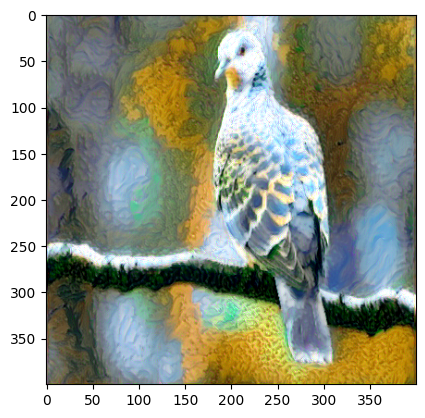

In [20]:
# Denormalize and show output
def show_image(tensor):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor(
        [0.485, 0.456, 0.406]
    ).view(3, 1, 1)
    image = image.clamp(0, 1)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.show()


show_image(target_img)